In [1]:
# https://medium.com/@bravinwasike18/building-a-deep-learning-model-with-keras-and-resnet-50-9dd6f4eb3351 참고
import tensorflow as tf
import numpy as np


from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.applications.resnet50 import ResNet50

from keras.preprocessing import image
from keras import layers

from keras.layers import Dense, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Flatten
from keras.models import Model, Sequential

import pathlib

# 로컬 데이터 경로 설정
data_dir = pathlib.Path("./dataset/")

height,width=180,180
training_batch_size=32

In [2]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    label_mode='categorical',
    labels="inferred",
    seed=123,
    image_size=(height,width),
    batch_size=training_batch_size
)

validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    label_mode='categorical',
    labels="inferred",
    seed=123,
    image_size=(height,width),
    batch_size=training_batch_size
)

class_names = train_ds.class_names
print(class_names)

Found 14001 files belonging to 14 classes.
Using 11201 files for training.
Found 14001 files belonging to 14 classes.
Using 2800 files for validation.
['Corn___Common_rust', 'Corn___Gray_leaf_spot', 'Corn___Northern_Leaf_Blight', 'Corn___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___healthy']


In [3]:
dnn_model = Sequential()

model= ResNet50(
    include_top=False,
    input_shape=(180,180,3),
    pooling='avg',
    classes=14,
    weights='imagenet')

for layer in model.layers:
    layer.trainable=False

In [4]:
dnn_model.add(model)
dnn_model.add(Flatten())
dnn_model.add(Dense(512, activation='relu'))
dnn_model.add(Dense(14, activation='softmax'))

In [5]:
dnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 14)                7182      
                                                                 
Total params: 24643982 (94.01 MB)
Trainable params: 1056270 (4.03 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [6]:
dnn_model.compile(
    optimizer="adam",
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [7]:
epochs=10
history = dnn_model.fit(
    train_ds, 
    validation_data=validation_ds, 
    epochs=epochs
)

Epoch 1/10
351/351 [==============================] - 235s 664ms/step - loss: 0.3485 - accuracy: 0.8874 - val_loss: 0.2675 - val_accuracy: 0.8968
Epoch 2/10
351/351 [==============================] - 241s 686ms/step - loss: 0.1291 - accuracy: 0.9532 - val_loss: 0.1566 - val_accuracy: 0.9432
Epoch 3/10
351/351 [==============================] - 242s 689ms/step - loss: 0.0842 - accuracy: 0.9701 - val_loss: 0.1058 - val_accuracy: 0.9643
Epoch 4/10
351/351 [==============================] - 245s 699ms/step - loss: 0.0638 - accuracy: 0.9779 - val_loss: 0.3554 - val_accuracy: 0.9114
Epoch 5/10
351/351 [==============================] - 241s 686ms/step - loss: 0.0513 - accuracy: 0.9814 - val_loss: 0.1246 - val_accuracy: 0.9636
Epoch 6/10
351/351 [==============================] - 241s 687ms/step - loss: 0.0458 - accuracy: 0.9838 - val_loss: 0.1239 - val_accuracy: 0.9625
Epoch 7/10
351/351 [==============================] - 239s 682ms/step - loss: 0.0275 - accuracy: 0.9908 - val_loss: 0.1310 -

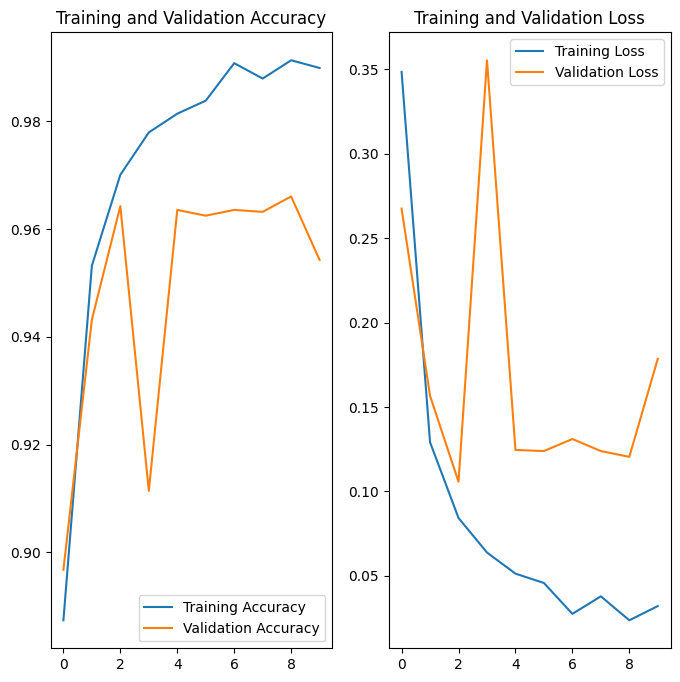

In [8]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [20]:
from keras.preprocessing import image
# 로컬 이미지 경로 설정
local_image_path = "./test-case/healthy_strawberry.jpg"

# 이미지 불러오기
img = image.load_img(local_image_path, target_size=(height, width))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # 배치 차원 추가

In [21]:
# 모델 예측
predictions = dnn_model.predict(img_array)


# 클래스 이름과 신뢰도 출력
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(predictions)], 100 * np.max(predictions))
)

1/1 [==============================] - 0s 52ms/step
This image most likely belongs to Strawberry___healthy with a 59.31 percent confidence.


In [11]:
# Save the entire model to a HDF5 file
dnn_model.save('model.h5')

/Users/donghyun/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## tensorflow light 로 변환하기

In [12]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(dnn_model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /var/folders/05/f27xdntx0w1d15nqqws7822w0000gn/T/tmpp5ad4tgm/assets


INFO:tensorflow:Assets written to: /var/folders/05/f27xdntx0w1d15nqqws7822w0000gn/T/tmpp5ad4tgm/assets
2023-10-24 17:12:48.049369: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2023-10-24 17:12:48.049383: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2023-10-24 17:12:48.049716: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/05/f27xdntx0w1d15nqqws7822w0000gn/T/tmpp5ad4tgm
2023-10-24 17:12:48.063515: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2023-10-24 17:12:48.063533: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /var/folders/05/f27xdntx0w1d15nqqws7822w0000gn/T/tmpp5ad4tgm
2023-10-24 17:12:48.091003: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:382] MLIR V1 optimization pass is not enabled
2023-10-24 17:12:48.108983: I tensorflow/cc/saved_model/load

In [13]:
import cv2


PATH_TO_MODEL = './model.tflite'

interpreter = tf.lite.Interpreter(model_path=PATH_TO_MODEL)
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the model on random input data.
input_shape = input_details[0]['shape']
input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)

[[2.7496703e-09 4.9494391e-09 1.0824238e-10 5.4487391e-08 3.0395710e-12
  1.0985613e-11 5.1783900e-08 3.6781600e-09 1.2315977e-08 1.7791257e-07
  9.9999940e-01 3.3088341e-07 1.8116525e-08 3.6306844e-10]]


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [14]:
interpreter.get_signature_list()

{'serving_default': {'inputs': ['resnet50_input'], 'outputs': ['dense_1']}}

In [22]:
classify_lite = interpreter.get_signature_runner('serving_default')
classify_lite

predictions_lite = classify_lite(resnet50_input = img_array)['dense_1']
score_lite = tf.nn.softmax(predictions_lite)

# 클래스 이름과 신뢰도 출력
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(predictions)], 100 * np.max(predictions))
)

print(np.max(np.abs(predictions - predictions_lite)))

This image most likely belongs to Strawberry___healthy with a 59.31 percent confidence.
7.748604e-07
